
# Training a TFNO on Darcy-Flow

In this example, we demonstrate how to use the small Darcy-Flow example we ship with the package
to train a Tensorized Fourier-Neural Operator


In [1]:
# %pip install tensorly
#%pip install zarr


In [2]:
import torch
import matplotlib.pyplot as plt
import sys
import os
# par_dir = os.getcwd()+ "/.."
# print(type(par_dir))
# print(sys.path)
# sys.path.append(os.path.dirname(par_dir))
# print(sys.path)
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

device = 'cpu'

/home/nikhil/anaconda3/envs/simbi/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_hip.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
        n_train=1000, batch_size=32, 
        test_resolutions=[16, 32], n_tests=[100, 50],
        test_batch_sizes=[32, 32],
)

UnitGaussianNormalizer init on 1000, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape torch.Size([1, 1, 1]), eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=32


We create a tensorized FNO model



In [4]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 393665 parameters.


Create the optimizer



In [5]:
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-3, 
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

Creating the losses



In [6]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [7]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): FactorizedSpectralConv(
      (weight): ModuleList(
        (0-7): 8 x ComplexTuckerTensor(shape=(32, 32, 8, 8), rank=(25, 25, 6, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): Lifting(
    (fc): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (projection): Projection(
    (fc1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    (fc2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.008
    lr: 0.008
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.training.losses.H1Loss object at 0x7f50946ba550>

 * Test: {'h1': <neuralop.training.losses.H1Loss object at

Create the trainer



In [8]:
trainer = Trainer(model, n_epochs=20,
                  device=device,
                  mg_patching_levels=0,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

Training on regular inputs (no multi-grid patching).


Actually train the model on our small Darcy-Flow dataset



In [9]:
trainer.train(train_loader, test_loaders,
              output_encoder,
              model, 
              optimizer,
              scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 1000 samples
Testing on [50, 50] samples         on resolutions [16, 32].
Training on raw inputs of size x.shape=torch.Size([32, 3, 16, 16]), y.shape=torch.Size([32, 1, 16, 16])
.. patched inputs of size x.shape=torch.Size([32, 3, 16, 16]), y.shape=torch.Size([32, 1, 16, 16])
Raw outputs of size out.shape=torch.Size([32, 1, 16, 16])
.. Processed (unpatched) outputs of size out.shape=torch.Size([32, 1, 16, 16])
[0] time=6.03, avg_loss=26.9317, train_err=0.5386, 16_h1=0.3827, 16_l2=0.2969, 32_h1=0.4592, 32_l2=0.3094
[3] time=4.09, avg_loss=11.9028, train_err=0.2381, 16_h1=0.3973, 16_l2=0.3313, 32_h1=0.5425, 32_l2=0.3738
[6] time=4.10, avg_loss=9.8373, train_err=0.1967, 16_h1=0.2018, 16_l2=0.1522, 32_h1=0.3461, 32_l2=0.1918
[9] time=4.95, avg_loss=9.0131, train_err=0.1803, 16_h1=0.1954, 16_l2=0.1503, 32_h1=0.3360, 32_l2=0.1851
[12] time=4.55, avg_loss=7.7866, train_err=0.1557, 16_h1=0.1585, 16_l2=0.1177, 32_h1=0.2950, 32_l2=0.1585
[15] time=5.36, avg_loss=7.2661, train_err=0.1

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



/tmp/ipykernel_216389/2926119135.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


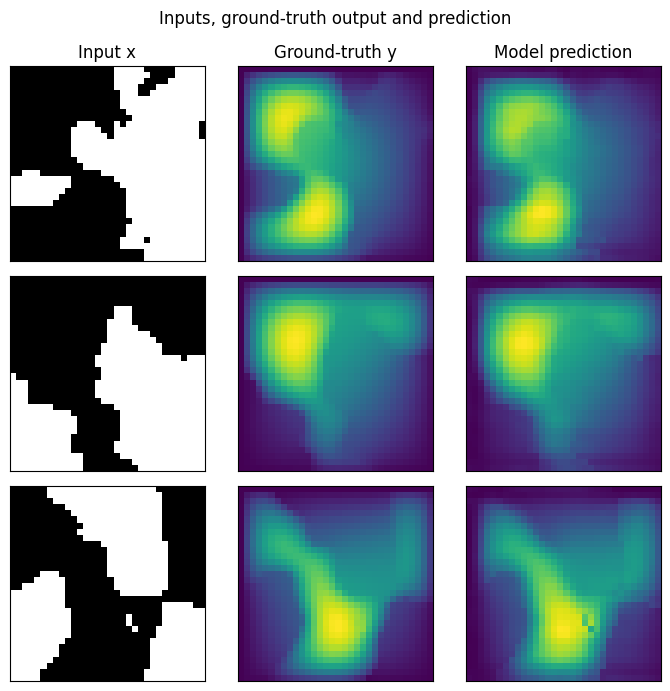

In [10]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction', y=0.98)
plt.tight_layout()
fig.show()

In [11]:
 test_samples = test_loaders[32].dataset
test_loaders[32]

In [12]:
import numpy as np

model(test_samples[2]['x'].unsqueeze(0)).squeeze().detach().numpy()

array([[-1.1083608 , -1.1214108 , -1.1389183 , ..., -1.1454191 ,
        -1.1443082 , -1.1433712 ],
       [-1.1248089 , -1.1394502 , -1.1234663 , ..., -1.0452571 ,
        -1.0606045 , -1.0850067 ],
       [-1.0632826 , -1.0628374 , -0.98844296, ..., -0.6605243 ,
        -0.77209014, -0.9083068 ],
       ...,
       [-1.1369265 , -1.127569  , -1.0839702 , ..., -0.9520949 ,
        -0.9917617 , -1.0215248 ],
       [-1.1139687 , -1.1185365 , -1.1022159 , ..., -0.9904994 ,
        -1.0192713 , -1.0466696 ],
       [-1.0908632 , -1.1156992 , -1.1074085 , ..., -0.9397389 ,
        -0.97957116, -1.0266593 ]], dtype=float32)

In [13]:
test_samples[2]['x'].unsqueeze(0)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0312, 0.0312, 0.0312,  ..., 0.0312, 0.0312, 0.0312],
          [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
          ...,
          [0.9062, 0.9062, 0.9062,  ..., 0.9062, 0.9062, 0.9062],
          [0.9375, 0.9375, 0.9375,  ..., 0.9375, 0.9375, 0.9375],
          [0.9688, 0.9688, 0.9688,  ..., 0.9688, 0.9688, 0.9688]],

         [[0.0000, 0.0312, 0.0625,  ..., 0.9062, 0.9375, 0.9688],
          [0.0000, 0.0312, 0.0625,  ..., 0.9062, 0.9375, 0.9688],
          [0.0000, 0.0312, 0.0625,  ..., 0

In [14]:
test_samples[2]['x']

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0312, 0.0312, 0.0312,  ..., 0.0312, 0.0312, 0.0312],
         [0.0625, 0.0625, 0.0625,  ..., 0.0625, 0.0625, 0.0625],
         ...,
         [0.9062, 0.9062, 0.9062,  ..., 0.9062, 0.9062, 0.9062],
         [0.9375, 0.9375, 0.9375,  ..., 0.9375, 0.9375, 0.9375],
         [0.9688, 0.9688, 0.9688,  ..., 0.9688, 0.9688, 0.9688]],

        [[0.0000, 0.0312, 0.0625,  ..., 0.9062, 0.9375, 0.9688],
         [0.0000, 0.0312, 0.0625,  ..., 0.9062, 0.9375, 0.9688],
         [0.0000, 0.0312, 0.0625,  ..., 0.9062, 0.9375, 0.

In [15]:
    K1 = torch.load('darcy_test_32/darcy_test_32.pt')

In [16]:
    x_te = K1['x'][:50, :, :].unsqueeze(1).type(torch.float32).clone()
    y_te = K1['y'][:50, :, :].unsqueeze(1).clone()

In [17]:
np.shape(test_samples[2]['x']), np.shape(y_te)

(torch.Size([3, 32, 32]), torch.Size([50, 1, 32, 32]))

In [18]:
x_te[2][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [27]:
    from tensor_dataset import *
    #from transforms import PositionalEmbedding
    
    te_db = TensorDataset(x_te, y_te,transform_x=PositionalEmbedding([[0,1],[0,1]], 0))

ModuleNotFoundError: No module named 'tensor_dataset'

In [20]:
    te_loader = torch.utils.data.DataLoader(te_db,batch_size=32, shuffle=False, 
                                            num_workers=0, pin_memory=True, persistent_workers=False)

NameError: name 'te_db' is not defined

In [89]:
    te_loaders = {32: te_loader}

In [90]:
    te_samples = te_loaders[32].dataset


In [91]:
te_samples[2]['y']

tensor([[[1.6487900575e-04, 2.7298897039e-03, 4.0033045225e-03,
           ..., 4.8183067702e-03, 4.0065795183e-03,
          2.6361187920e-03],
         [2.7486244217e-03, 7.0306695998e-02, 1.1045861989e-01,
           ..., 1.3610957563e-01, 1.1008996516e-01,
          6.7277550697e-02],
         [4.1475803591e-03, 1.1395390332e-01, 1.8633565307e-01,
           ..., 2.3096522689e-01, 1.8325555325e-01,
          1.0781790316e-01],
         ...,
         [6.9879565854e-04, 2.1712537855e-02, 4.0510553867e-02,
           ..., 3.8783509284e-02, 2.7589337900e-02,
          1.4638232999e-02],
         [5.6337175192e-04, 1.6935665160e-02, 3.0068708584e-02,
           ..., 2.7502866462e-02, 1.9801370800e-02,
          1.0689987801e-02],
         [4.9141608179e-04, 1.3468847610e-02, 1.8014920875e-02,
           ..., 1.4568173327e-02, 1.0672790930e-02,
          5.9433109127e-03]]])

In [92]:
PositionalEmbedding([[0,1],[0,1]], 0).__call__

<bound method PositionalEmbedding.__call__ of <transforms.PositionalEmbedding object at 0x7f15c8608a60>>

In [93]:
torch.cat((y_te, x_te.squeeze(0), y_te.squeeze(0)), dim=0)

tensor([[[[1.7661465972e-04, 3.1266564038e-03, 4.8438753001e-03,
            ..., 7.7396770939e-04, 5.3946539992e-04,
           2.9796815943e-04],
          [3.1268284656e-03, 8.3077497780e-02, 1.3740435243e-01,
            ..., 2.3968463764e-02, 1.6444856301e-02,
           8.6890766397e-03],
          [4.8451907933e-03, 1.3743659854e-01, 2.3538722098e-01,
            ..., 4.3717313558e-02, 2.9886754230e-02,
           1.5497001819e-02],
          ...,
          [5.3635486402e-03, 1.5409485996e-01, 2.6635545492e-01,
            ..., 4.6299181879e-02, 3.2389003783e-02,
           1.6947416589e-02],
          [4.3674726039e-03, 1.2199471891e-01, 2.0667740703e-01,
            ..., 3.2714005560e-02, 2.3120982572e-02,
           1.2285232544e-02],
          [2.8134884778e-03, 7.3128119111e-02, 1.1932579428e-01,
            ..., 1.7203684896e-02, 1.2348551303e-02,
           6.7478739657e-03]]],


        [[[1.8190020637e-04, 3.3010919578e-03, 5.1874937490e-03,
            ..., 5.827066954

/tmp/ipykernel_23054/2765645370.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


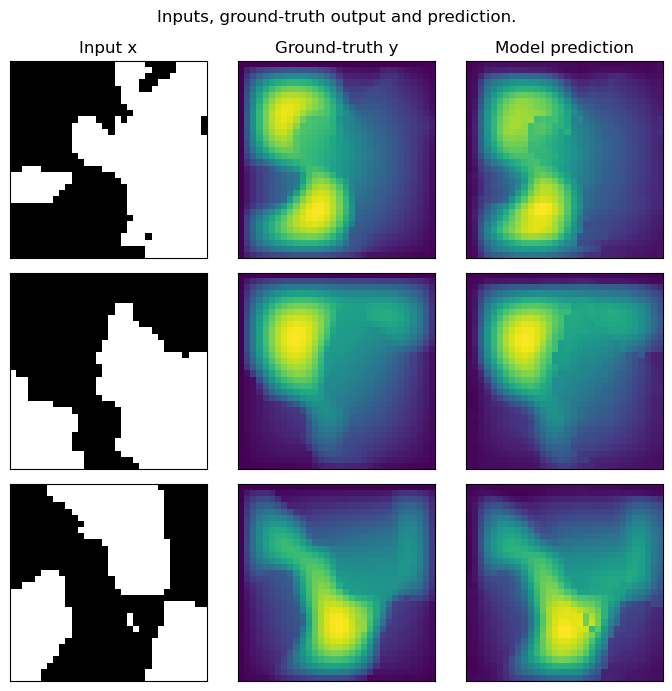

In [94]:

fig = plt.figure(figsize=(7, 7))
for ind in range(3):
    da = te_samples[ind]
    # Input x
    x1 = da['x']
    # Ground-truth
    y1 = da['y']
    # Model prediction
    out1 = model(x1.unsqueeze(0))

    ax1 = fig.add_subplot(3, 3, ind*3 + 1)
    ax1.imshow(x1[0], cmap='gray')
    if ind == 0: 
        ax1.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax1 = fig.add_subplot(3, 3, ind*3 + 2)
    ax1.imshow(y1.squeeze())
    if ind == 0: 
        ax1.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax1 = fig.add_subplot(3, 3, ind*3 + 3)
    ax1.imshow(out1.squeeze().detach().numpy())
    if ind == 0: 
        ax1.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

/tmp/ipykernel_23054/721110919.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


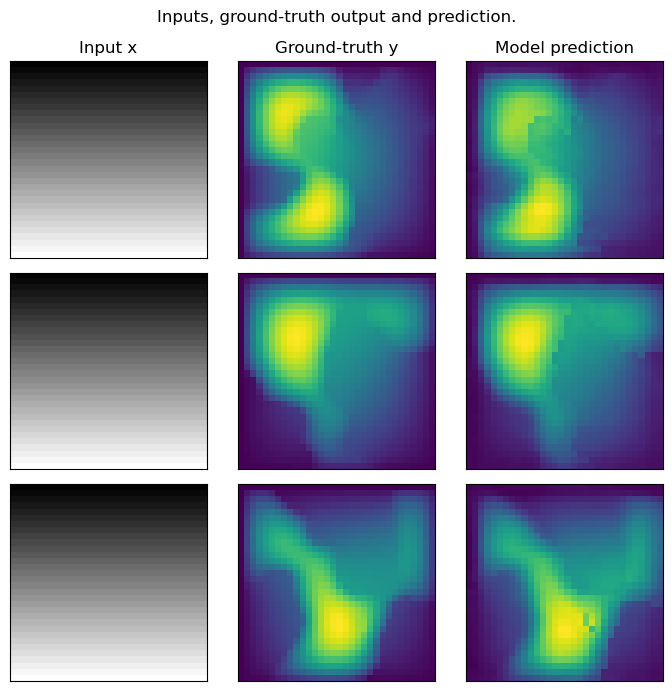

In [95]:
fig = plt.figure(figsize=(7, 7))

row = 3
for ind in range(row):
    da = te_samples[ind]
    # Input x
    x1 = da['x']
    # Ground-truth
    y1 = da['y']
    # Model prediction
    out1 = model(x1.unsqueeze(0))

    ax1 = fig.add_subplot(row, 3, ind*3 + 1)
    ax1.imshow(x1[1], cmap='gray')
    if ind == 0: 
        ax1.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax1 = fig.add_subplot(row, 3, ind*3 + 2)
    ax1.imshow(y1[0])
    if ind == 0: 
        ax1.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax1 = fig.add_subplot(row, 3, ind*3 + 3)
    ax1.imshow(out1.squeeze().detach().numpy())
    if ind == 0: 
        ax1.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

In [96]:
x_te[2][0][23]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.])

In [97]:
te_samples[2]['x'][2]

tensor([[0.0000000000, 0.0312500000, 0.0625000000,  ..., 0.9062500000,
         0.9375000000, 0.9687500000],
        [0.0000000000, 0.0312500000, 0.0625000000,  ..., 0.9062500000,
         0.9375000000, 0.9687500000],
        [0.0000000000, 0.0312500000, 0.0625000000,  ..., 0.9062500000,
         0.9375000000, 0.9687500000],
        ...,
        [0.0000000000, 0.0312500000, 0.0625000000,  ..., 0.9062500000,
         0.9375000000, 0.9687500000],
        [0.0000000000, 0.0312500000, 0.0625000000,  ..., 0.9062500000,
         0.9375000000, 0.9687500000],
        [0.0000000000, 0.0312500000, 0.0625000000,  ..., 0.9062500000,
         0.9375000000, 0.9687500000]])

In [98]:
te_db[0]['x']

tensor([[[0.0000000000, 0.0000000000, 0.0000000000,  ..., 1.0000000000,
          1.0000000000, 1.0000000000],
         [0.0000000000, 0.0000000000, 0.0000000000,  ..., 1.0000000000,
          1.0000000000, 1.0000000000],
         [0.0000000000, 0.0000000000, 0.0000000000,  ..., 1.0000000000,
          1.0000000000, 1.0000000000],
         ...,
         [0.0000000000, 0.0000000000, 0.0000000000,  ..., 1.0000000000,
          1.0000000000, 1.0000000000],
         [0.0000000000, 0.0000000000, 0.0000000000,  ..., 1.0000000000,
          1.0000000000, 1.0000000000],
         [0.0000000000, 0.0000000000, 0.0000000000,  ..., 1.0000000000,
          1.0000000000, 1.0000000000]],

        [[0.0000000000, 0.0000000000, 0.0000000000,  ..., 0.0000000000,
          0.0000000000, 0.0000000000],
         [0.0312500000, 0.0312500000, 0.0312500000,  ..., 0.0312500000,
          0.0312500000, 0.0312500000],
         [0.0625000000, 0.0625000000, 0.0625000000,  ..., 0.0625000000,
          0.0625000000, 

In [99]:
import numpy as np
import h5py, os

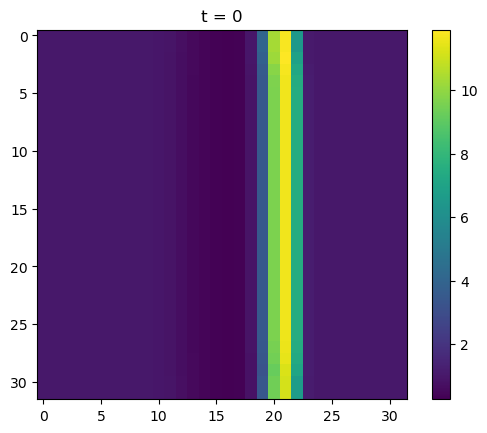

0.9997366070747375

In [100]:
with h5py.File('28.chkpt.000_200.h5') as f:
    c = np.sqrt(2)
    x = np.copy(f['rho'])
    xn = np.reshape(x, (32,32))
    k = xn
    #torch.set_printoptions(precision=10)
    xn1 = torch.from_numpy(k).float()
    plt.imshow(xn) #vmin = 0, vmax = 3.2)
    plt.colorbar()
    plt.title("t = 0")
    #plt.savefig('density%03d.png'%(0))
    plt.show()
xn1[0,8].item()

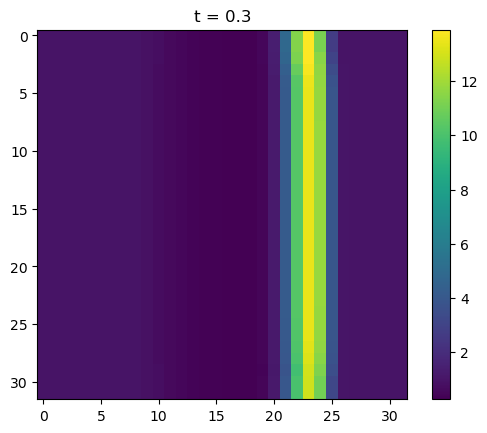

1.0

In [101]:
with h5py.File('28.chkpt.000_300.h5') as f1:
    c = np.sqrt(2)
    x5 = np.copy(f1['rho'])
    xn5 = np.reshape(x5, (32,32))
    k5 = xn5**1
    #torch.set_printoptions(precision=10)
    xn5 = torch.from_numpy(k5).float()
    plt.imshow(xn5) #vmin = 0, vmax = 3.2)
    plt.colorbar()
    plt.title("t = 0.3")
    #plt.savefig('density%03d.png'%(0))
    plt.show()
xn5[0,31].item()

In [102]:
np.shape(x)

(1024,)

In [103]:
#xn = np.reshape(x, (32,32))

In [104]:
#xn[0,31]

/tmp/ipykernel_23054/1988696880.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


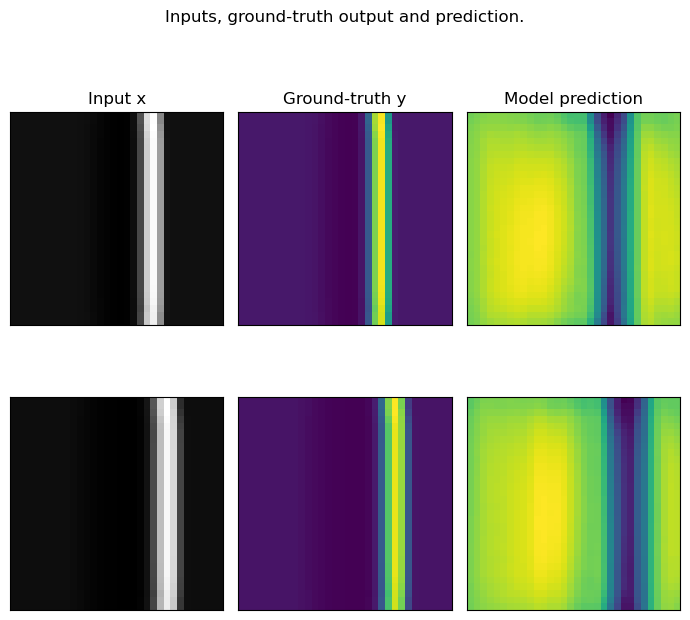

In [105]:
fig = plt.figure(figsize=(7, 7))

row = 2
for ind in range(row):
    da = te_samples[0]
    # Input x
    x1 = da['x']
    if ind == 0:
        x1[0] = xn1
    else:
        x1[0] = xn5
    # Ground-truth
    y1 = da['y']
    # Model prediction
    out1 = model(x1.unsqueeze(0))

    ax1 = fig.add_subplot(row, 3, ind*3 + 1)
    ax1.imshow(x1[0], cmap='gray')
    if ind == 0: 
        ax1.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax1 = fig.add_subplot(row, 3, ind*3 + 2)
    if ind == 0:
        ax1.imshow(xn1)
        ax1.set_title('Ground-truth y')
    else:
        ax1.imshow(xn5)
    plt.xticks([], [])
    plt.yticks([], [])

    ax1 = fig.add_subplot(row, 3, ind*3 + 3)
    ax1.imshow(out1.squeeze().detach().numpy())
    if ind == 0: 
        ax1.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

In [106]:
np.shape(xn1)

torch.Size([32, 32])

In [107]:
xn1 = torch.from_numpy(xn*(1./3.)).float()

In [108]:
xn[0,16]*1./3.

0.09240803402915948

In [109]:
torch.set_printoptions(precision=10)

In [110]:
xn1 = torch.from_numpy(xn*(1./3.)).float()

In [111]:
xn1[0,16]

tensor(0.0924080312)

In [112]:
    K2 = torch.load('darcy_train_16.pt')

In [113]:
    x_te1 = K2['x'][:1000, :, :].unsqueeze(1).type(torch.float32).clone()
    y_te1 = K2['y'][:1000, :, :].unsqueeze(1).clone()

In [114]:
np.shape(y_te1)

torch.Size([1000, 1, 16, 16])

In [115]:
x_te1[999]

tensor([[[1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
         [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [1., 1., 1., 1.,

In [116]:
    te_db1 = TensorDataset(x_te1, y_te1,transform_x=PositionalEmbedding([[0,1],[0,1]], 0))

In [117]:
 te_loader1 = torch.utils.data.DataLoader(te_db1,batch_size=16, shuffle=False, 
                                            num_workers=0, pin_memory=True, persistent_workers=False)

In [118]:
    te_loaders1 = {16: te_loader1}

In [119]:
    te_samples1 = te_loaders1[16].dataset


In [120]:
te_samples1[999]['y'][0]

tensor([[1.2389930816e-05, 4.0632678429e-04, 4.6736505465e-04, 1.3961776858e-03,
         3.8426097017e-03, 4.1917646304e-03, 3.6104037426e-03, 1.5960169258e-03,
         1.2779056560e-03, 1.1683362536e-03, 1.1133062653e-03, 5.7975463569e-03,
         6.6013322212e-03, 6.2013976276e-03, 5.2567622624e-03, 3.8315264974e-03],
        [4.5682242489e-04, 2.4490892887e-02, 2.4043351412e-02, 1.0720110685e-01,
         1.6496020555e-01, 1.8225651979e-01, 1.5028981864e-01, 9.1426208615e-02,
         7.5574792922e-02, 6.9958060980e-02, 1.3369858265e-01, 3.0809807777e-01,
         3.4173533320e-01, 3.0971986055e-01, 2.4494899809e-01, 1.6904245317e-01],
        [7.8404718079e-04, 4.7289483249e-02, 9.6911378205e-02, 1.4221425354e-01,
         1.7851544917e-01, 2.1226891875e-01, 1.7859312892e-01, 1.4921569824e-01,
         1.2957422435e-01, 1.2465066463e-01, 3.9728179574e-01, 5.3546005487e-01,
         5.4127717018e-01, 4.5268219709e-01, 2.8241607547e-01, 2.3702436686e-01],
        [9.8212331068e-04

In [121]:
torch.max(te_samples1[999]['y'][0])

tensor(0.8977042437)

/tmp/ipykernel_23054/4125397676.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


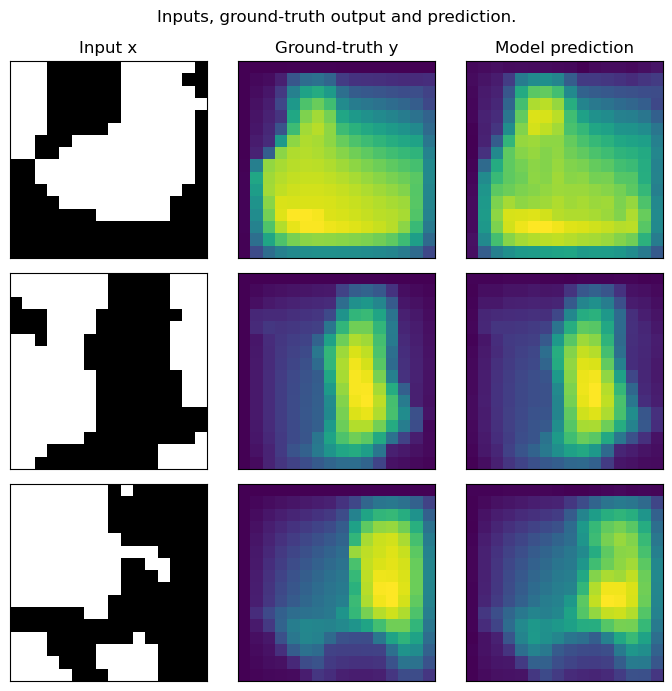

In [122]:
fig1 = plt.figure(figsize=(7, 7))
for ind1 in range(3):
    da1 = te_samples1[ind1]
    # Input x
    x2 = da1['x']
    # Ground-truth
    y2 = da1['y']
    # Model prediction
    out2 = model(x2.unsqueeze(0))

    ax2 = fig1.add_subplot(3, 3, ind1*3 + 1)
    ax2.imshow(x2[0], cmap='gray')
    if ind1 == 0: 
        ax2.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax2 = fig1.add_subplot(3, 3, ind1*3 + 2)
    ax2.imshow(y2.squeeze())
    if ind1 == 0: 
        ax2.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax2 = fig1.add_subplot(3, 3, ind1*3 + 3)
    ax2.imshow(out2.squeeze().detach().numpy())
    if ind1 == 0: 
        ax2.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig1.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig1.show()

In [ ]:
    K3 = torch.load('NavierStokes_V1e-4_N10000_T30.pt')